In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from feature_stabilization import stabilize_video
from time import sleep
from torchvision import transforms, models
import warnings
warnings.filterwarnings("ignore")
device = 'cuda'
h,w = 128,128
H,W = 720,1024

In [2]:
def show_flow(flow):
    hsv_mask = np.zeros(shape= flow.shape[:-1] +(3,),dtype = np.uint8)
    hsv_mask[...,1] = 255
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1],angleInDegrees=True)
    hsv_mask[:,:,0] = ang /2 
    hsv_mask[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv_mask,cv2.COLOR_HSV2RGB)
    return(rgb)
def warpFlow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    warped = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return(warped)
def fixBorder(frame, cropping = 1.02):
    s = frame.shape
    # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1] / 2, s[0] / 2), 0, cropping)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [3]:
def get_flow(img1,img2,raft):
    img1 = torch.from_numpy((img1 / 255.0)*2 -1).float().unsqueeze(0).permute(0,3,1,2).to(device) 
    img2 = torch.from_numpy((img2 / 255.0)*2 -1).float().unsqueeze(0).permute(0,3,1,2).to(device)
    with torch.no_grad():
        flow = raft(img1,img2)[-1]
    return flow.squeeze(0).permute(1,2,0).cpu().numpy()

In [4]:
path = 'E:/Datasets/DeepStab_Dataset/unstable/18.avi'
#path = './data/Zooming/1.avi'
cap = cv2.VideoCapture(path)
frames = []
while True:
    ret,frame = cap.read()
    if not ret: break
    frame = cv2.resize(frame,(W,H))
    frames.append(frame)
cap.release()
frames = np.array(frames, np.uint8)

In [5]:
stable_frames = frames

In [6]:
raft = models.optical_flow.raft_small(weights = 'Raft_Small_Weights.C_T_V2').eval().to(device)

cv2.namedWindow('window',cv2.WINDOW_NORMAL)
num_frames= stable_frames.shape[0]
flows = np.zeros((num_frames,h,w,2),dtype = np.float32)
prev = cv2.resize(stable_frames[0,...],(w,h))
for idx in range(1,num_frames-1):
    curr = cv2.resize(stable_frames[idx,...],(w,h))
    flows[idx,...] = get_flow(prev,curr,raft)
    rgb_flow = show_flow(flows[idx,...])
    prev = curr
    print(f'\r idx: {idx+1}/{num_frames}',end='')
    cv2.imshow('window',rgb_flow)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()

del raft

 idx: 249/250

In [7]:
original_trajectories = np.cumsum(flows,axis = 0)
original_trajectories = torch.from_numpy(original_trajectories).float().to(device)
bytes_size = original_trajectories.element_size() * original_trajectories.nelement()
smooth_trajectories = original_trajectories.clone().requires_grad_(True)
print(f'Memory size :{bytes_size / (1024 ** 2)} MB')

Memory size :31.25 MB


In [8]:
lr = 1
optimizer = torch.optim.Adam([smooth_trajectories], lr=lr)
ITERATIONS = 500
for step in range(ITERATIONS):
    # Calculate the deviation from the original trajectories
    deviation_term = 0.2 * torch.mean((smooth_trajectories - original_trajectories)**2)
    
    # Calculate the smoothness term
    smoothness_term =  20 * torch.mean((smooth_trajectories[1:] - smooth_trajectories[:-1])**2)
    # Balance the two terms using a parameter alpha
    loss = smoothness_term #+ deviation_term

    # Perform backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'\rStep {step}, Loss: {loss.item()}',end='')

Step 499, Loss: 0.8519008159637451

In [9]:
smooth_trajectories.shape

torch.Size([250, 128, 128, 2])

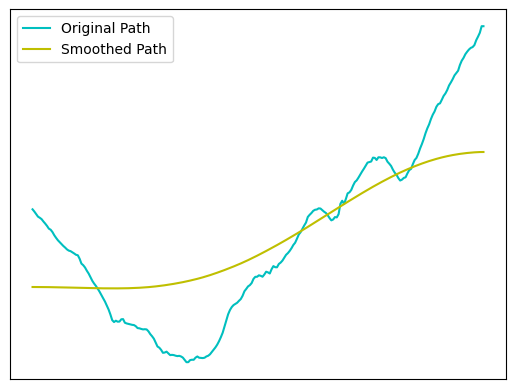

In [11]:
smooth_trajectories = smooth_trajectories.cpu().detach()
original_trajectories = original_trajectories.cpu()
warps = smooth_trajectories - original_trajectories
plt.plot(original_trajectories[:,10,10,0], color = 'c',label = 'Original Path')
plt.plot(smooth_trajectories[:,10,10,0], color = 'y', label = 'Smoothed Path')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [19]:
def gaussian_blur(input, kernel_size, sigma):
    device  = input.device
    x = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    y = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid(x, y)
    kernel = torch.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / torch.sum(kernel)

    # Assuming the input is in the shape (batch_size, channels, height, width)
    channels = input.shape[1]
    kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(channels, channels, 1, 1).to(device)

    padding = kernel_size // 2
    blurred = F.conv2d(input, kernel, padding=padding)
    return blurred

In [20]:
blurred_flows = gaussian_blur(warps.permute(0,3,1,2),kernel_size=5,sigma=1).cpu()
blurred_flows = blurred_flows.permute(0,2,3,1).numpy()

In [21]:
cv2.namedWindow('window',cv2.WINDOW_NORMAL)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./2.avi', fourcc, 30.0, (W, H))
warped_frames = stable_frames.copy()
for idx in range(num_frames):
    flow = cv2.resize(blurred_flows[idx,...],(W,H))
    img = warped_frames[idx,...] 
    warped = warpFlow(img,flow)
    warped = fixBorder(warped,cropping=1.0)
    warped_frames[idx,...] = warped 
    out.write(warped)
    cv2.imshow('window',warped)
    sleep(1/30)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()
out.release()

In [22]:
from metrics import metric
metric('E:/Datasets/DeepStab_Dataset/unstable/2.avi','2.avi')

Frame: 446/447
cropping score:1.000	distortion score:0.982	stability:0.669	pixel:0.986


(0.9997905526255594, 0.9819316, 0.6694580013524283, 0.9859652817249298)